<a href="https://colab.research.google.com/github/hritvikgupta/Sentiment-tweet-Prediction-NLP/blob/master/Copy_of_Sentiment_tweet_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import re

import string
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
## initializing the stemmer
ps = nltk.PorterStemmer()




from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
## Downloading the stop words
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("english")
stopwords[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Twitter-NLP/train_E6oV3lV.csv")
test = pd.read_csv("/content/drive/My Drive/Twitter-NLP/test_tweets_anuFYb8.csv")

In [ ]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
len(train)

31962

In [ ]:
test.head(), len(test)

(      id                                              tweet
 0  31963  #studiolife #aislife #requires #passion #dedic...
 1  31964   @user #white #supremacists want everyone to s...
 2  31965  safe ways to heal your #acne!!    #altwaystohe...
 3  31966  is the hp and the cursed child book up for res...
 4  31967    3rd #bihday to my amazing, hilarious #nephew..., 17197)

## Visualizing the data

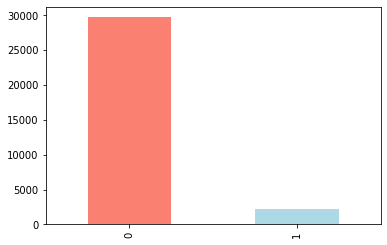

In [ ]:
train['label'].value_counts().plot(kind = 'bar', color = ['salmon', 'lightblue'])

In [ ]:
data = train.drop('id', axis=1)
data_test = test.drop('id', axis =1)
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
##Creating the feature body_len for the better prediction of the sentiment tweet analysis
data['body_len'] = data['tweet'].apply(lambda x : len(x) - x.count(" "))
data_test['body_len'] = data_test['tweet'].apply(lambda x: len(x) - x.count(" "))

In [ ]:
data.head()

,label,tweet,body_len
0,0,@user when a father is dysfunctional and is s...,82
1,0,@user @user thanks for #lyft credit i can't us...,101
2,0,bihday your majesty,17
3,0,#model i love u take with u all the time in ...,70
4,0,factsguide: society now #motivation,32


## Cleaning of our Data

** The twitter handle has masked the @user for the privacy reasons
   so for @user has to be removed as this give us hardly any information

** we also get rid of the punctuations, numbers, and even special characters as they
   dont help us to provide information about any of the sentiment 
   tweet

** removing the stopwords


#### 1st step removing the @user

np.vectorize work similarly as that of the mapping function

In [ ]:
## lets first combine the train and test data for our convienvce to doing same task again and again
combi = train.append(test, ignore_index = True)
## function for removing the @user from all our tweets in our data
pattern = '@[\w]*'
def remove_pattern(input_txt):
  r = re.findall('@[\w]*' , input_txt)
  for i in r:
    input_txt = re.sub(i,'', input_txt)

  return input_txt

## remove the twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'])

#tfdif = TfidfVectorizer(analyzer = remove_pattern)
#tfidf_t = tfdif.fit_transform(test['tweet'])

In [ ]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


## Cleaning/preprocessing Data

 Now as we have removed the @user now lets clean up the data

## Here we are defining function to clean the data by using following steps

* Removing the short words
* Here we do not remove punctuation as we did it spam mail detection

* Tokenization
* Stemming


In [ ]:
def clean_txt(txt):
  txt = ' '.join([w for w in txt.split() if len(w)>3])
  #txt = "".join([word.lower() for word in txt if word not in string.punctuation])
  tokens = txt.split()
  txt = [ps.stem(word) for word in tokens]
  return txt

### spliting the each line in text function do the cleaning manually

In [ ]:
## Getting the rid of the short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't cause they don't off...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0.0,factsguide: society now #motivation,factsguide: society #motivation


In [ ]:
## Tokenization (making the list of words in every sentence)
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet

0        [when, father, dysfunctional, selfish, drags, ...
1        [thanks, #lyft, credit, can't, cause, they, do...
2                                  [bihday, your, majesty]
3        [#model, love, take, with, time, urð±!!!, ð...
4                      [factsguide:, society, #motivation]
                               ...                        
49154    [thought, factory:, left-right, polarisation!,...
49155    [feeling, like, mermaid, ð, #hairflip, #nev...
49156    [#hillary, #campaigned, today, #ohio((omg)), &...
49157    [happy,, work, conference:, right, mindset, le...
49158    [song, glad", free, download!, #shoegaze, #new...
Name: tidy_tweet, Length: 49159, dtype: object

In [ ]:
## Stemming 
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, can't, caus, they, don'...
2                              [bihday, your, majesti]
3    [#model, love, take, with, time, urð±!!!, ð...
4                       [factsguide:, societi, #motiv]
Name: tidy_tweet, dtype: object

In [ ]:
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet


In [ ]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit can't caus they don't offer...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0.0,factsguide: society now #motivation,factsguide: societi #motiv


## Visualization of the tweets

* Understanding the commom ==n words used in the tweets

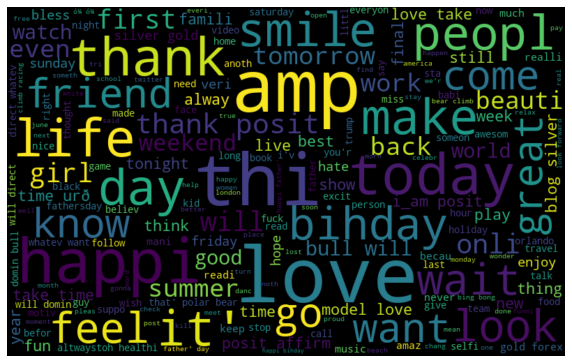

In [ ]:
## we use word cloud wherein the most frequent word used appear to be larger
## and the less frequent words appear in smaller in size

all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

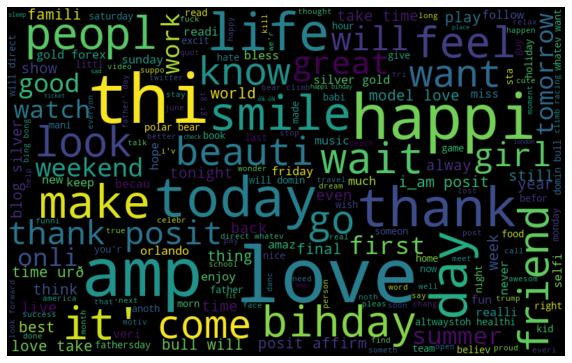

In [ ]:
## Word that are non-raciest tweets

all_words = ' '.join([text for text in combi['tidy_tweet'][combi['label']==0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

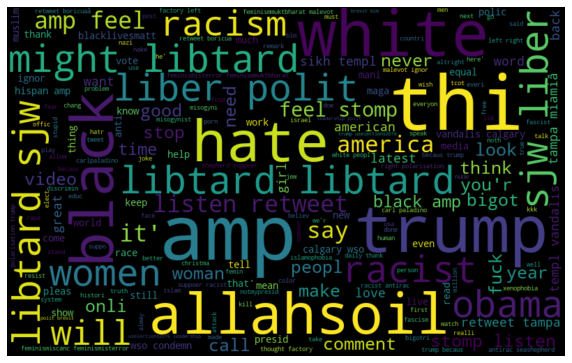

In [ ]:
## Words that are raciest 
all_words = ' '.join([text for text in combi['tidy_tweet'][combi['label']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

## Understanding the impact of the hashtags on the tweets

In [ ]:
## defining the function to store the hashtags
def hashtags_extract(x):
  hashtags = []
  ## loop over each word in the tweet
  for i in x:
    ht = re.findall(r"#(\w+)", i)
    hashtags.append(ht)

  return hashtags   

In [ ]:
## extracting hashtags from the raciest tweet
ht_negative = hashtags_extract(combi['tidy_tweet'][combi['label']==1])
## Extracting hashtags from non-raciest tweet
ht_positive = hashtags_extract(combi['tidy_tweet'][combi['label']==0])


In [ ]:
#ht_pos = sum(ht_positive)
ht_pos = sum(ht_positive,[])
ht_neg = sum(ht_negative,[])

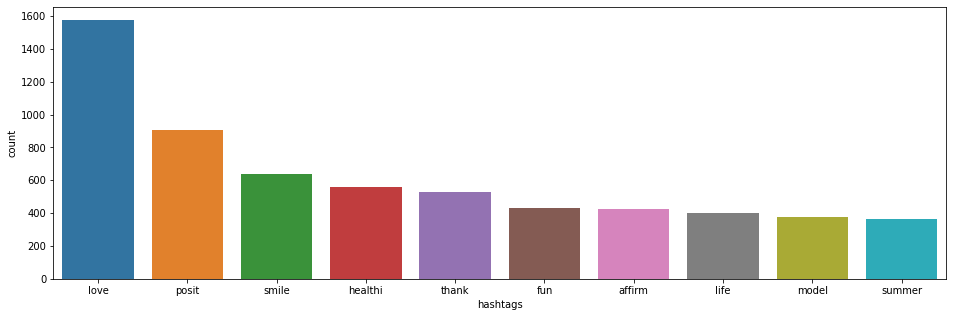

In [ ]:
## Now plotting most frequent non-raciest tweets
a = nltk.FreqDist(ht_pos)
# here a returns the dictionary of hashtags corresponding to their repeated values
d = pd.DataFrame({'hashtags':list(a.keys()),
                  "count": list(a.values())})

## Selecting the most frequent hashtags
d = d.nlargest(columns = 'count', n = 10)
plt.figure(figsize = (16,5))
ax = sns.barplot(data = d, x = 'hashtags', y = 'count')
ax.set(ylabel= 'count')
plt.show()

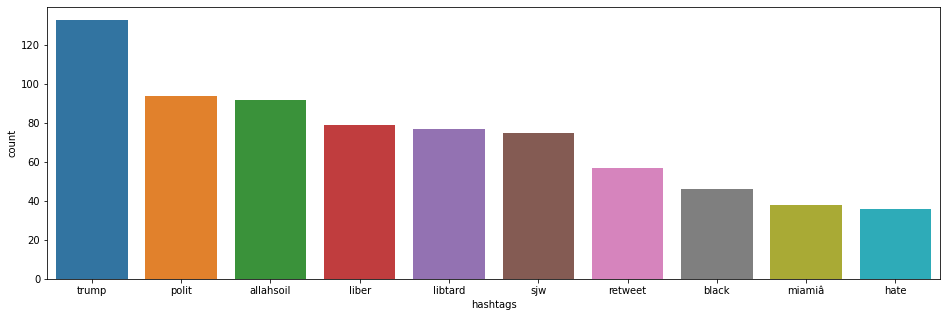

In [ ]:
## Now plotting most frequent raciest tweets
b = nltk.FreqDist(ht_neg)
# here a returns the dictionary of hashtags corresponding to their repeated values
e = pd.DataFrame({'hashtags':list(b.keys()),
                  "count": list(b.values())})

## Selecting the most frequent hashtags
e = e.nlargest(columns = 'count', n = 10)
plt.figure(figsize = (16,5))
ax = sns.barplot(data = e, x = 'hashtags', y = 'count')
ax.set(ylabel= 'count')
plt.show()

## Vectorizing the Data

In [ ]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'])

In [ ]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: " ".join(clean_txt(x)))

In [ ]:
X = train.drop('label', axis = 1)
X = train.drop('id', axis = 1)
y = train['label']

In [ ]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words= 'english')
tfidf_vect_fit = tfdf_vect.fit(X_train['tidy_tweet'])

tfidf_train = tfidf_vect_fit.transform(X_train['tidy_tweet'])
tfidf_test = tfidf_vect_fit.transform(X_test['tidy_tweet'])

X_feature_train = pd.DataFrame(tfidf_train.toarray())
X_feature_test = pd.DataFrame(tfidf_test.toarray())

In [ ]:
X_feature_train.shape, y_train.shape

((22373, 1000), (22373,))

## Building the model 

In [ ]:
models = {
   "RandomForest": RandomForestClassifier(),
   "KNN": KNeighborsClassifier(),
   "GradientBoost": GradientBoostingClassifier(),
   "LogisticRegressor": LogisticRegression()
}

## Create the function to fit and score the model
def fit_score(models, X_train, X_test, y_train, y_test):
  np.random.seed(42)
  model_score = {}
  for name, model in models.items():
    model.fit(X_train, y_train)
    model_score[name] = model.score(X_test, y_test)

  return model_score


model_scores = fit_score(models = models,
                         X_train = X_feature_train,
                         X_test = X_feature_test,
                         y_train = y_train,
                         y_test = y_test)

model_scores



{'GradientBoost': 0.9424340390030242,
 'KNN': 0.9369068724580248,
 'LogisticRegressor': 0.9466054854520806,
 'RandomForest': 0.9472312024194389}

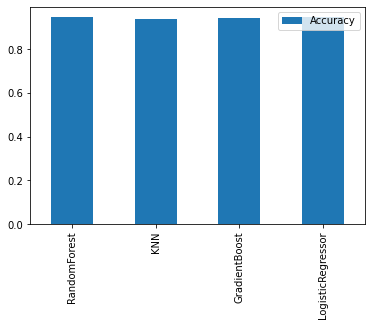

In [ ]:
## model comparison
model_compare = pd.DataFrame(model_scores, index = ['Accuracy'])
model_compare.T.plot.bar()

In [ ]:
## Predicting on the model which has got the highest score
rf = RandomForestClassifier()
rf.fit(X_feature_train, y_train)

prediction = rf.predict_proba(X_feature_test)

In [ ]:
prediction_int = prediction[:,1]>0.3
prediction_int = prediction_int.astype(np.int)

In [ ]:
print(classification_report(y_test, prediction_int))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8905
           1       0.57      0.54      0.56       684

    accuracy                           0.94      9589
   macro avg       0.77      0.75      0.76      9589
weighted avg       0.94      0.94      0.94      9589



In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, prediction_int)

0.5553047404063206

In [ ]:
pred_df = pd.DataFrame(y_test)
pred_df['RandomForest'] = prediction_int
pred_df.head()

,label,RandomForest
12227,0,0
14709,0,0
19319,0,0
4308,0,0
24055,0,0


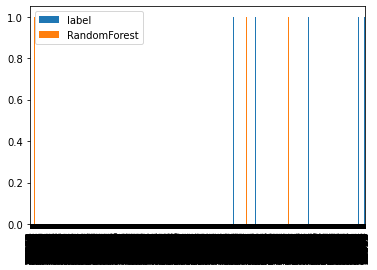

In [ ]:
pred_df.plot(kind = 'bar')

## confusion Matrix

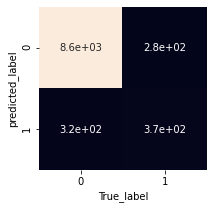

In [ ]:
# create a function to plot the confusion matriz
def plot_conf(y_test, y_preds):
  fig, ax = plt.subplots(figsize = (3,3))
  ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                   annot = True,
                   cbar = False)
  
  plt.xlabel('True_label')
  plt.ylabel("predicted_label")

plot_conf(y_test, prediction_int)

## Plotting the ROC and AUC curve

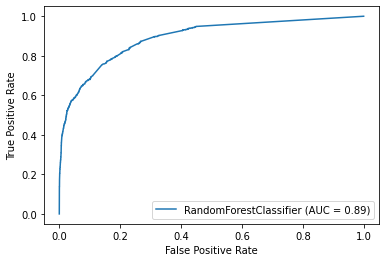

In [ ]:
def plot_roc(model, X_feature_test, y_test):
  plot_roc_curve(model, X_feature_test, y_test)


plot_roc(rf, X_feature_test, y_test)